Can we use the EG Uma spectrum to measure the Lya line?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import lightkurve as lk


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
spath = '../hst_spectra/eg_uma_COS_FUV_1291_2017-12-05.dat'
w, f, e, dq=  np.loadtxt(spath, unpack=True)
w, f, e = w[dq==0], f[dq==0], e[dq==0]

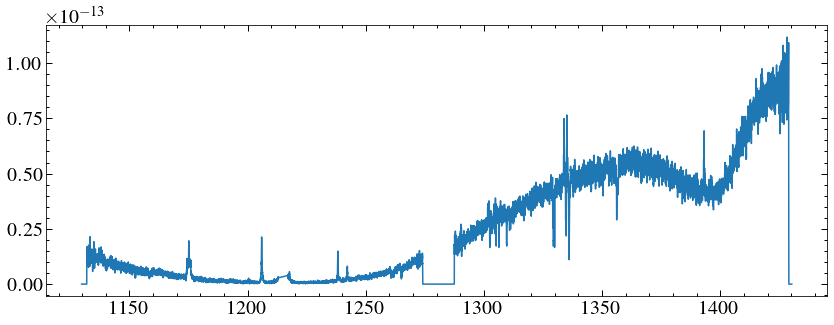

In [3]:
smooth=5
f = convolve(f,Box1DKernel(smooth))
e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
#plt.plot(w,f)
#plt.xlim(1210, 1220)
mask = (w < 1213) | (w > 1217)
wl, fl, el = w, f, e #retain to plot airglow
w, f, e = w[mask], f[mask], e[mask]
plt.plot(w,f)
#plt.xlim(1210, 1220)


In [4]:
lya = fits.getdata('hlsp_muscles_model_lya-reconstruction_gj1214_na_v22_component-spec.fits', 1)
g140m = fits.getdata('hlsp_muscles_hst_stis_gj1214_g140m_v22_component-spec.fits', 1)

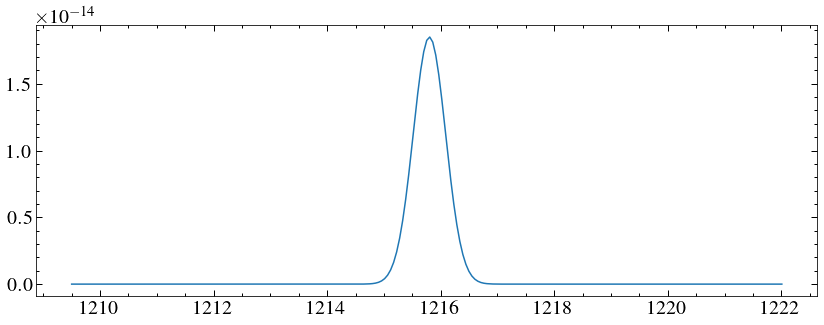

In [5]:
plt.plot(lya['WAVELENGTH'], lya['FLUX'])

In [6]:
#distance scale
p_eg = 34.83367384548251e-3
p_gj = 68.26534018946352e-3
scale = (p_eg/p_gj)**2
print(1/p_eg, 1/p_gj)
print(scale)

28.707853338578794 14.648722136659709
0.26037425760309946


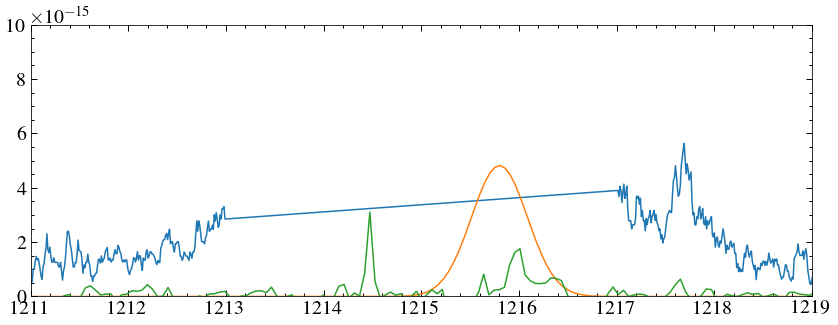

In [7]:
plt.plot(w,f)
plt.plot(lya['WAVELENGTH'], lya['FLUX']*scale)
plt.xlim(1211, 1219)
plt.ylim(0, 0.1e-13)
plt.plot(g140m['WAVELENGTH'], g140m['FLUX']*scale)

In [8]:
rv = -29 + -125.9


In [9]:
lyalam = 1215.67
newlam = (rv*u.km/u.s).to(u.AA, equivalencies=u.doppler_optical(lyalam*u.AA))
print(newlam)

1215.0418745152688 Angstrom


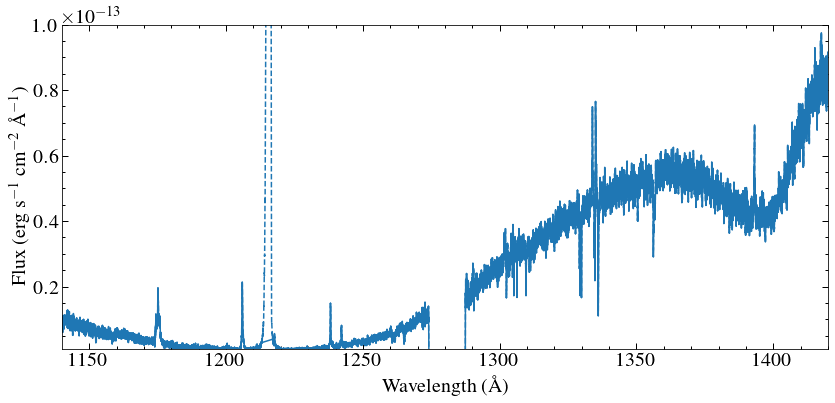

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(w,f)
plt.plot(wl,fl, ls='--', c='C0', zorder = -1)
plt.ylim(0.1e-14, 1e-13)
plt.xlim(1140, 1420)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
#plt.savefig('plots/eg_uma_cos.png')

In [11]:
#model
mw, mf = np.loadtxt('../models/DA_EG-UMA.dk', unpack=True, skiprows=34)

(1100.0, 1500.0)

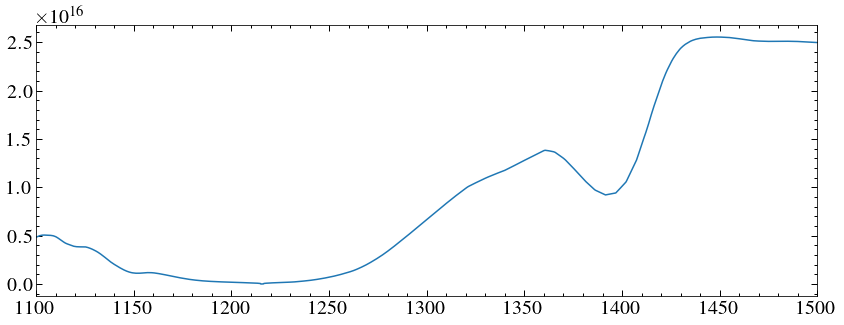

In [12]:

plt.plot(mw, mf)
plt.xlim(1100, 1500)

In [13]:
from scipy.optimize import leastsq


def residuals(scale, f, mf):
    return f - mf/scale


In [14]:
mmask = (mw > w[0]) & (mw < w[-1])
mw1, mf1 = mw[mmask], mf[mmask]

mf1 = interp1d(mw1, mf1, fill_value='extrapolate')(w)
normfac = leastsq(residuals, 1., args=(f, mf1))[0]

print(normfac)

[2.51732437e+29]


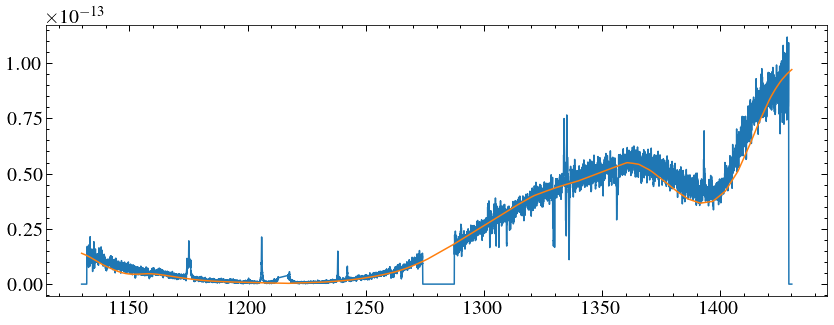

(0.0, 3.897208422623074e-14)

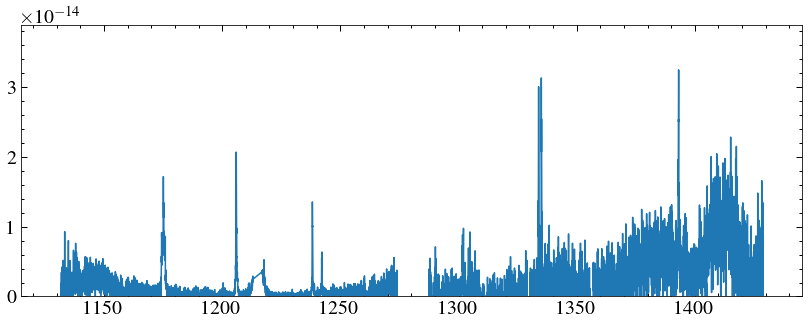

In [15]:
plt.plot(w,f)
plt.plot(w, mf1/normfac)
plt.show()

f2 = f-(mf1/normfac)

plt.plot(w, f2)
plt.ylim(0)
#plt.yscale('log')

Line measurements

In [16]:
savdat = Table([w, f2, e], names=['WAVELENGTH', 'FLUX', 'ERROR'])
ascii.write(savdat, 'wd_removed_eguma.ecsv', format='ecsv', overwrite=True)

In [17]:
linelist = Table.read('/home/david/work/muscles/FUV_linelist.csv')

In [18]:
mask = (linelist['Wavelength'] > w[0]) & (linelist['Wavelength'] < w[-1]) & (linelist['Likelihood to measure'] == 'High')
cutlist = linelist[mask]


(0.0, 3.897208422623074e-14)

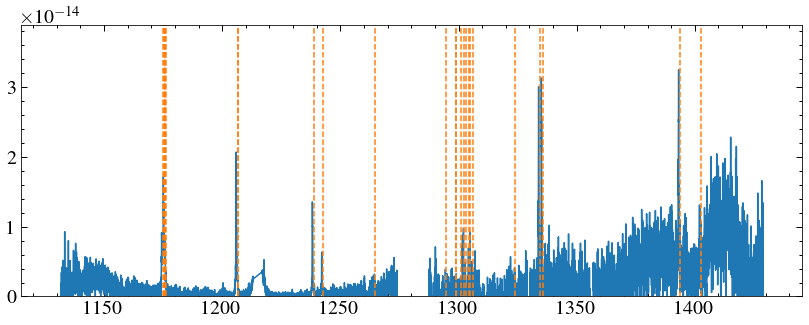

In [19]:
plt.plot(w, f2)
[plt.axvline(line, c='C1', ls='--') for line in cutlist['Wavelength']]
plt.ylim(0)

In [20]:
"""for i, line in enumerate(cutlist['Wavelength']):
    mask = (w > line-2) & (w <line+2)
    plt.plot(w[mask], f[mask])
    plt.axvline(line, c='C1', ls='--')
    print(cutlist['Ion'][i])
    #plt.ylim(0)
    plt.show()"""

#need to move this to it's own script to interact with lines

"for i, line in enumerate(cutlist['Wavelength']):\n    mask = (w > line-2) & (w <line+2)\n    plt.plot(w[mask], f[mask])\n    plt.axvline(line, c='C1', ls='--')\n    print(cutlist['Ion'][i])\n    #plt.ylim(0)\n    plt.show()"

In [21]:
line_pos = Table.read('lines_to_measure.ecsv')
line_pos = line_pos[line_pos['Xs'] !=  -1.0]
#line_pos = line_pos #Si 1206 is in there twice for some reason

C III 1174.935
1.4058137042972485e-14 1.393479079020943e-15
54.46465386457396 km / s


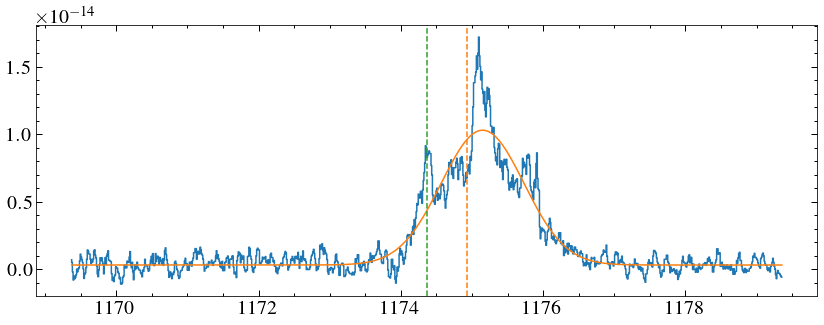

C III 1175.592
1.4022637304636501e-14 1.3389851625459342e-15
-113.11733669853439 km / s


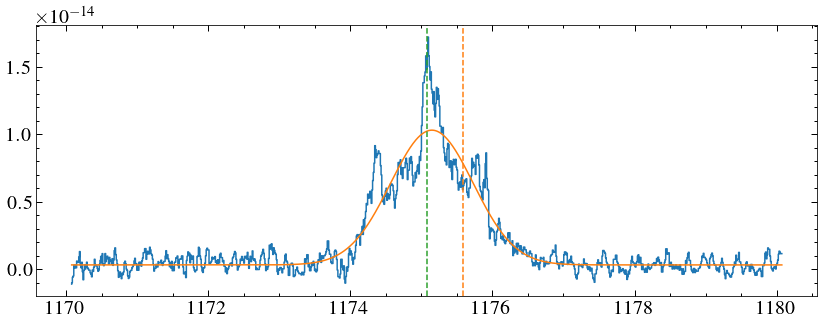

C III 1175.713
1.4000681773989589e-14 1.3149160573386537e-15
-143.959630431302 km / s


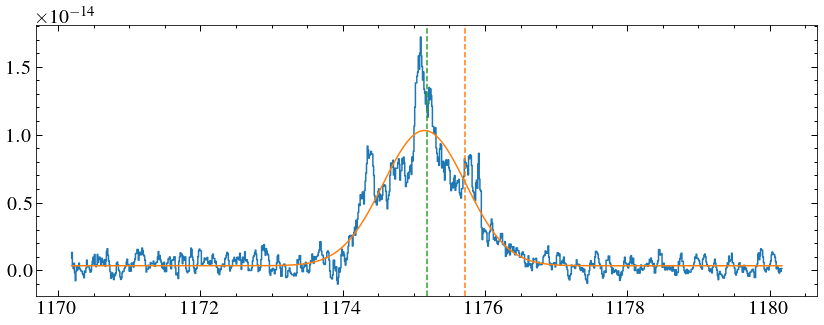

C III 1175.713
1.4000681773989589e-14 1.3149160573386537e-15
-143.959630431302 km / s


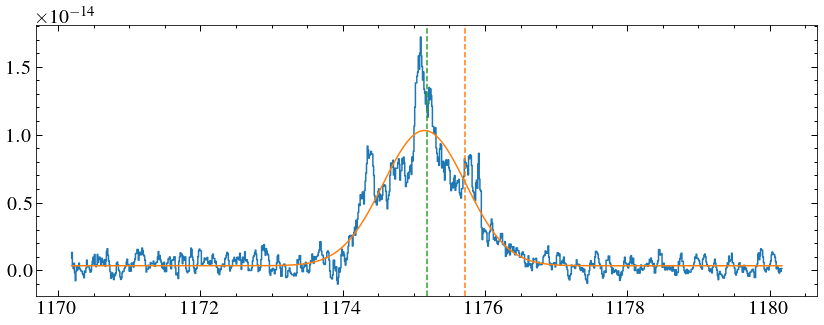

C III 1175.989
1.3886764552413064e-14 1.2207904077286847e-15
-214.3066525161752 km / s


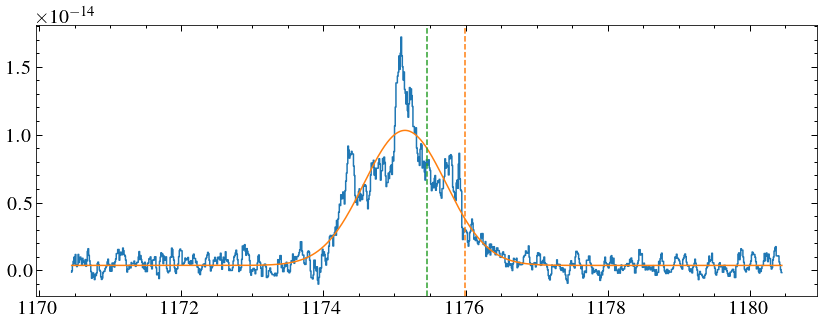

C III 1176.372
1.3921628342363543e-14 1.2445387963923181e-15
-311.8400207394005 km / s


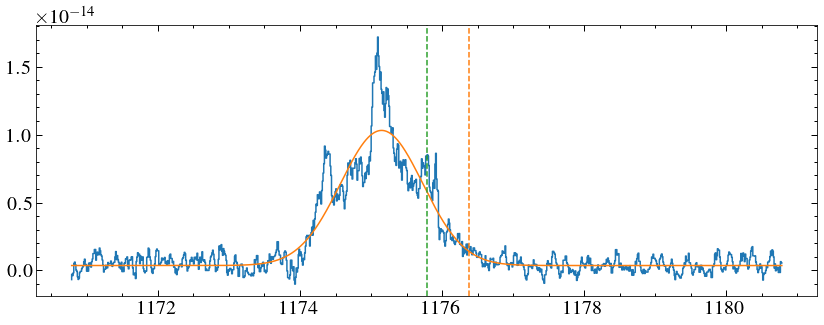

Si III 1206.499
7.103022338054591e-15 3.9428677388888392e-16
-135.7974063659453 km / s


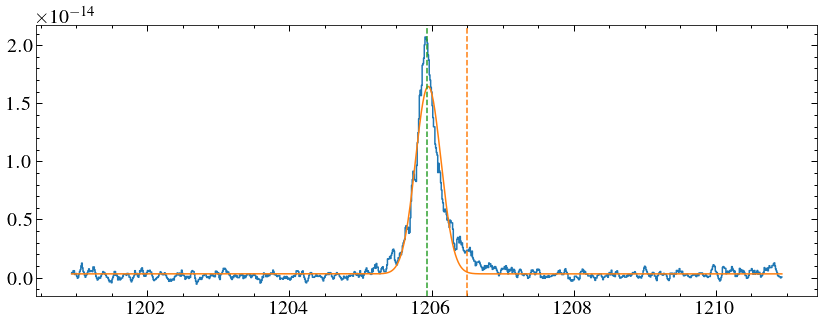

Si III 1206.499
7.103022338054591e-15 3.9428677388888392e-16
-135.7974063659453 km / s


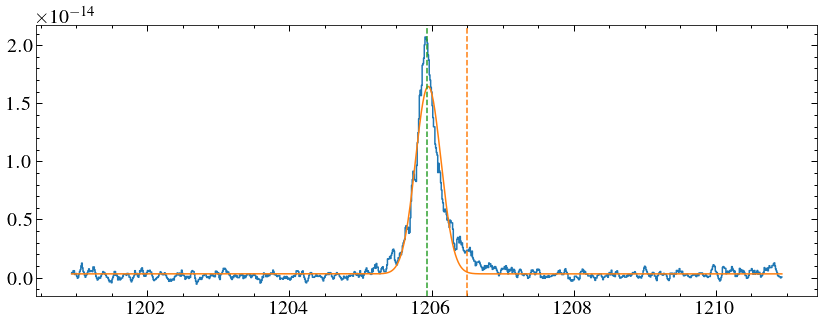

N V 1238.821
3.4106395113459034e-15 3.0592122670299098e-16
-153.44964144208686 km / s


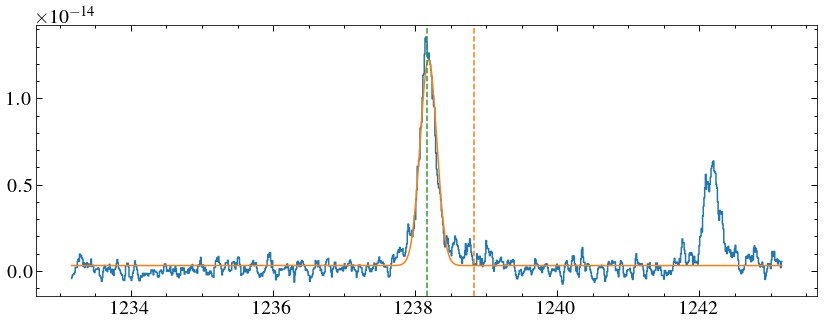

N V 1242.804
1.292184386009404e-15 2.431721086395581e-16
-148.79215518031947 km / s


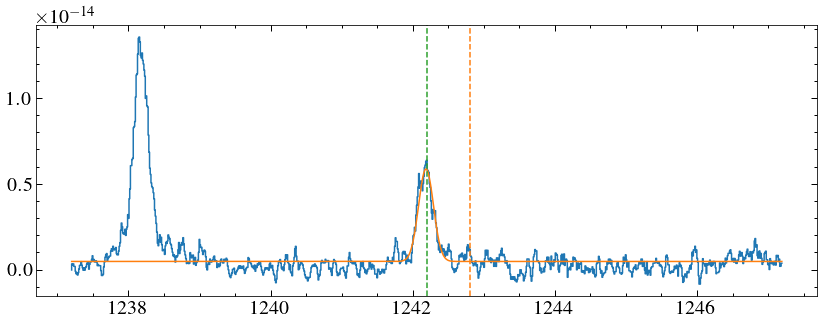

ValueError: Input must be 1- or 2-d.

In [24]:
def gauss_flux(amp, std, off, ae, se, oe):
    """
    Calcualates the flux and error of a Gaussian with amplitude and stddev amp and std, with offset off
    """
    off_err = 0
    if off != 0.0:
        amp += (-1*off)
        off_err = (oe/off)**2
        
    flux = ((2*np.pi)**0.5) * amp * std
    error = flux * (((ae/amp)**2)+((se/std)**2)+off_err)**0.5
    return flux, error

fitter = fitting.LevMarLSQFitter()

ions = []
rest = []
dvs = []
lineflux =[]
linefluxerror = []

guess_stds = [0.1,0.1, 0.1, 0.01, 0.1, 0.1, 0.1, 0.1]

for i, lrow in enumerate(line_pos):
    row = linelist[np.where(lrow['FILENAME'] == linelist['Wavelength'])[0][0]]
    ions.append(row['Ion'])
    rest.append(row['Wavelength'])
    guess = lrow['Xs']
    mask =  (w > guess-5) & (w <guess+5) #(f2 > -1e-14) &
    wline, fline, eline = w[mask], f2[mask], e[mask]
    gg_init = models.Const1D(0.0)+models.Gaussian1D(1e-14, guess,0.1, bounds=dict(amplitude=[0,1]))
    #gg_init = models.Const1D(0.0)+models.Voigt1D(x_0=guess, amplitude_L=2e-14, fwhm_L=0.5, fwhm_G=0.9)
    gg_fit = fitter(gg_init, wline, fline, weights = 1/eline, maxiter=10000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    plt.step(wline,fline)
    plt.plot(wline, gg_fit(wline))
    plt.axvline(row['Wavelength'], ls='--', c='C1')
    plt.axvline(guess, ls='--', c='C2')
    
    
    rest_lam = row['Wavelength']*u.AA
    obs_lam = gg_fit[1].mean*u.AA
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
    dvs.append(dv.value)
    
    off, oe = gg_fit[0].amplitude, fit_e[0]
    amp, ae = gg_fit[1].amplitude, fit_e[1],
    std, se = gg_fit[1].stddev, fit_e[2]
    f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
    lineflux.append(f_l)
    linefluxerror.append(e_l)
    print(row['Ion'], row['Wavelength'])
    print(f_l, e_l)
    
    print(dv)
    plt.show()
    
linestab = Table([ions, rest*u.AA, lineflux*u.erg/u.s/u.cm**2, linefluxerror*u.erg/u.s/u.cm**2, dvs*u.km/u.s], names=['ION', 'WAVELENGTH', 'FLUX', 'ERROR', 'VELOCITY'])

In [ ]:
#ascii.write(linestab, 'eg_uma_line_fluxes.ecsv', format='ecsv')

Redo with subspectra to reduce orbital smeering. But let's have a break and look at TESS. Is there evidence for elipsodal modulation?

In [ ]:
eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',
'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']


fitter = fitting.LevMarLSQFitter()




for tessfits in eg_uma_fits:
    hdul = fits.open(tessfits)
    #data = fits.getdata(tessfits, 1)
    data = hdul[1].data
    hdr = hdul[0].header
    print(hdr['RA_OBJ'], hdr['DEC_OBJ'])
    hdul.close()
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
    #fit = np.polyval((np.polyfit(t,f,1)), t)
    #f = (f/fit)-1
    #e = (e/fit)-1
    plt.figure(figsize=(20, 6))
    lc = lk.LightCurve(time=t, flux=f, flux_err=e).remove_outliers(sigma=5).flatten(window_length=1001).remove_nans()
    lc.flux -= 1
    lc.flux  *= 100
    lc.flux_err *= 100
    
    plt.subplot(131)

    
    
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=25*u.day)
    plt.plot(pg.period, pg.power)
    plt.xscale('log')
    
    plt.subplot(132)
    plt.scatter(lc.time,lc.flux, s=5)
    
    sin_mod =  models.Sine1D(amplitude=pg.max_power, frequency= pg.frequency_at_max_power.value)#, bounds={'phase':[0, 2*np.pi]})
    sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    timefit = np.linspace(lc.time[0], lc.time[-1], 2000)
    plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
    print('Period =', (1/sin_fit.frequency.value)*24, (sin_fit_e[1]/(sin_fit.frequency.value**2))*24, 'h')
    print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0]*100)

    

    print(pg.period_at_max_power.to(u.hour))
    plt.subplot(133)
    lcf = lc.fold(1/sin_fit.frequency).bin(50)
    plt.scatter(lcf.time, lcf.flux, s=5)
    

In [ ]:
eg_uma_fits= ['/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2019226182529-s0015-0000000416538823-0151-s/tess2019226182529-s0015-0000000416538823-0151-s_lc.fits',
'/home/david/work/pceb/tess/MAST_2020-07-23T1832/TESS/tess2020049080258-s0022-0000000416538823-0174-s/tess2020049080258-s0022-0000000416538823-0174-s_lc.fits']

for i, tessfits in enumerate(eg_uma_fits):
    data = fits.getdata(tessfits,1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
    lc0 = lk.LightCurve(time=t, flux=f, flux_err=e).remove_outliers(sigma=5).flatten(window_length=1001).remove_nans()#.remove_outliers(3)
    if i == 0:
        lc = lc0
    else:
        lc = lc.append(lc0)

        
lc.flux -= 1
lc.flux  *= 100
lc.flux_err *= 100



plt.figure(figsize=(20, 6))
plt.subplot(131)



pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=25*u.day)
plt.plot(pg.period, pg.power)
plt.xscale('log')

plt.subplot(132)
plt.scatter(lc.time,lc.flux, s=5)

sin_mod =  models.Sine1D(amplitude=pg.max_power, frequency= pg.frequency_at_max_power.value)#, bounds={'phase':[0, 2*np.pi]})
sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
timefit = np.linspace(lc.time[0], lc.time[-1], 2000)
plt.plot(timefit, sin_fit(timefit), c='C1', lw=2) 
print('Period =', (1/sin_fit.frequency.value)*24, (sin_fit_e[1]/(sin_fit.frequency.value**2))*24, 'h')
print('Period =', (1/sin_fit.frequency.value)*24*60, (sin_fit_e[1]/(sin_fit.frequency.value**2))*24*60, 'm')
print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0]*100)



#print(pg.period_at_max_power.to(u.hour))
plt.subplot(133)
lcf = lc.fold(1/sin_fit.frequency)#.bin(20)
plt.scatter(lcf.time, lcf.flux, s=5)
sin_mod2 =  models.Sine1D(amplitude=sin_mod.amplitude, frequency= 1, fixed=dict(frequency=True))#, bounds={'phase':[0, 2*np.pi]})
sin_fit2 = fitter(sin_mod2, lcf.time, lcf.flux, weights = 1/lcf.flux_err)
plt.plot(lcf.time, sin_fit2(lcf.time), c='C1')


Need to clean out flares - doing this in stella

In [ ]:
"""for i, tessfits in enumerate(eg_uma_fits):
    data = fits.getdata(tessfits,1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
    lc = lk.LightCurve(time=t, flux=f, flux_err=e).remove_outliers(sigma=5).flatten(window_length=1001).remove_nans()#.remove_outliers(3)
    plt.scatter(lc.time,lc.flux, s=5)
  #  plt.xlim(1711, 1714)
    chunk_size = 10
    flare_times = []
    flare_flux = []
    flare_error = []
    for i in range(len(lc.flux)):
        if i > chunksize and i < len(lc.flux)-(chunksize):
            chunk = lc[i-chunk_size:i-5].append(lc[i+5:i+chunk_size])
            cmed, cstd = np.median(chunk.flux), np.std(chunk.flux)
            if lc.flux[i] > cmed+3*cstd and lc.flux[i+1] > cmed+3*cstd:
                flare_times.append(lc.time[i])
                flare_flux.append(lc.flux[i])
                flare_error.append(lc.flux_err[i])
                
    print(len(flare_times))
    flare_lc = lk.LightCurve(time=flare_times, flux=flare_flux, flux_err=flare_error)
    plt.scatter(flare_lc.time,flare_lc.flux)

    plt.show()"""

Looking at individaul spectra

In [ ]:
path = '/media/david/5tb_storage1/pceb_data/eg_uma/'
x1ds = glob.glob('{}*x1d.fits'.format(path))
x1ds

In [ ]:
smooth=5
for x in x1ds:
    data = fits.getdata(x, 1)
    hdr = fits.getheader(x,1)
    print(hdr['EXPSTART'])
    w = np.array([], dtype=float)
    f = np.array([], dtype=float)
    e = np.array([], dtype=float)
    for dt in data[::-1]:
        wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
        mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
        wi, fi, ei = wi[mask], fi[mask], ei[mask]
        w = np.concatenate((w, wi))
        f = np.concatenate((f, fi))
        e = np.concatenate((e, ei))    
        
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    
    mmask = (mw > w[0]) & (mw < w[-1])
    mw1, mf1 = mw[mmask], mf[mmask]

    mf1 = interp1d(mw1, mf1, fill_value='extrapolate')(w)
    normfac = leastsq(residuals, 1., args=(f, mf1))[0]
    f2 = f-(mf1/normfac)

    plt.plot(w, f2)
    plt.xlim(1320, 1350)
    
   # plt.plot(w, f)
    plt.show()
   
    


In [ ]:
all_f = []
all_e = []
all_dv = []
times = []

for x in x1ds:
    data = fits.getdata(x, 1)
    hdr = fits.getheader(x,1)
    times.append((hdr['EXPSTART']+hdr['EXPEND'])/2)
    w = np.array([], dtype=float)
    f = np.array([], dtype=float)
    e = np.array([], dtype=float)
    for dt in data[::-1]:
        wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
        mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
        wi, fi, ei = wi[mask], fi[mask], ei[mask]
        w = np.concatenate((w, wi))
        f = np.concatenate((f, fi))
        e = np.concatenate((e, ei))    
        
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    
    mmask = (mw > w[0]) & (mw < w[-1])
    mw1, mf1 = mw[mmask], mf[mmask]

    mf1 = interp1d(mw1, mf1, fill_value='extrapolate')(w)
    normfac = leastsq(residuals, 1., args=(f, mf1))[0]
    f2 = f-(mf1/normfac)

    ions = []
    rest = []
    dvs = []
    lineflux =[]
    linefluxerror = []

    
    for lrow in line_pos:
        row = linelist[np.where(lrow['FILENAME'] == linelist['Wavelength'])[0][0]]
        ions.append(row['Ion'])
        rest.append(row['Wavelength'])
        guess = lrow['Xs']
        mask =  (w > guess-4) & (w <guess+4) #(f2 > -1e-14) &
        wline, fline, eline = w[mask], f2[mask], e[mask]
        gg_init = models.Const1D(0.0)+models.Gaussian1D(2e-14, guess,0.05, bounds = dict(amplitude=[0,1]))
        #gg_init = models.Const1D(0.0)+models.Voigt1D(x_0=guess, amplitude_L=2e-14, fwhm_L=0.5, fwhm_G=0.9)
        gg_fit = fitter(gg_init, wline, fline, weights = 1/eline, maxiter=10000)
        #print(fitter.fit_info['param_cov'])
     #   plt.step(wline,fline)
      #  plt.plot(wline, gg_fit(wline))
       # plt.axvline(row['Wavelength'], ls='--', c='C1')
       # plt.axvline(guess, ls='--', c='C2')


        rest_lam = row['Wavelength']*u.AA
        obs_lam = gg_fit[1].mean*u.AA
        dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))

        if type(fitter.fit_info['param_cov']) == np.ndarray:
            fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
       
            off, oe = gg_fit[0].amplitude, fit_e[0]
            amp, ae = gg_fit[1].amplitude, fit_e[1],
            std, se = gg_fit[1].stddev, fit_e[2]
            f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
            lineflux.append(f_l)
            linefluxerror.append(e_l)
            dvs.append(dv.value)
        else:
            lineflux.append(-1)
            linefluxerror.append(-1)
            dvs.append(-1)
        

     #   print(row['Ion'], row['Wavelength'])
      #  print(f_l, e_l)

       # print(dv)
        #plt.show()
    all_f.append(lineflux)
    all_e.append(linefluxerror)
    all_dv.append(dvs)
#print(all_f)
all_f, all_e, all_dv, times = np.array(all_f), np.array(all_e), np.array(all_dv), np.array(times)

plt.figure(figsize=(12, 12))
for i, ion in enumerate(ions):
    fion, eion, dvion= all_f[:,i], all_e[:,i], all_dv[:,i]
    mask = fion != -1
    plt.subplot(211)
    plt.errorbar(times[mask], fion[mask], eion[mask])
    plt.yscale('log')
    plt.subplot(212)
    plt.errorbar(times[mask],dvion[mask])
    

No real change in flux. AY has done a Lya estimation, let's see how it looks.

In [ ]:
lydat = Table.read('EGUMa_LyA_ISM_estimate.txt', format='ascii.basic')

In [ ]:
lydat.dtype.names

In [ ]:
linestab['VELOCITY']